### 1. Prediction calibration

In [ ]:
import importlib
import numpy as np
import matplotlib.pylab as plt
from matplotlib import rc
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fbeta_score
import pandas as pd


import support_functions
import uncertainty_data_path_consts as data_constants

PAUQ_DB_PATH = "/pauq/pauq_databases"
EHRSQL_MIMIC_PATH = "data/mimic_iv/mimic_iv.sqlite"

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':15})

# Set the font used for MathJax - more on this later
rc('mathtext',**{'default':'regular'})
%config InlineBackend.figure_format = 'retina'

importlib.reload(support_functions)
importlib.reload(data_constants)

### Calibration plots

In [2]:
def make_naive_calibration(dev_sc, dev_tr, test_sc, test_tr):
    min_score, max_score = np.min(dev_sc, axis=0), np.max(dev_sc, axis=0)
    calibrated_score = (test_sc - min_score) / (max_score - min_score)
    proba_pos_class = np.clip(calibrated_score, 0, 1)
    return proba_pos_class

def make_sigmoid_calibration(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    calibrated_test_scores = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='sigmoid').fit(dev_scores, dev_targets)
        calibrated_cls_pred = calibrated_cls.predict_proba(test_scores)[:, 1]
        calibrated_test_scores.append(calibrated_cls_pred)
    
    calibrated_test_scores = np.array(calibrated_test_scores).T
    return calibrated_test_scores

def make_isotonic_calibration(dev_sc, dev_tr, test_sc, test_tr):
    seed_number = range(dev_sc.shape[1])
    calibrated_test_scores = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(dev_scores, dev_targets)
        calibrated_cls_pred = calibrated_cls.predict_proba(test_scores)[:, 1]
        calibrated_test_scores.append(calibrated_cls_pred)
    
    calibrated_test_scores = np.array(calibrated_test_scores).T
    return calibrated_test_scores

def score_by_gmm(dev_sc, dev_tr, test_sc, test_tr):
    BETA_FINE = 3
    seed_number = range(dev_sc.shape[1])
    predicted_test_targets = []
    predicted_test_targets_proba = []
    for i in seed_number:
        lr = LogisticRegression(random_state=42)
        
        dev_scores = dev_sc[:, i].reshape(-1,1)
        dev_targets = dev_tr[:, i]
        test_scores = test_sc[:, i].reshape(-1,1)
        
        calibrated_cls = CalibratedClassifierCV(lr, cv=3, method='isotonic').fit(dev_scores, dev_targets)
        calibrated_cls_test = calibrated_cls.predict_proba(test_scores)[:, 1].reshape(-1,1)
        
        gmm = GaussianMixture(n_components=2, random_state=42).fit(calibrated_cls_test)
        
        calibrated_cls_pred_target = gmm.predict(calibrated_cls_test)
        calibrated_cls_pred_target_inverted = [1 if x == 0 else 0 for x in calibrated_cls_pred_target]
        
        calibrated_cls_pred_proba = gmm.predict_proba(calibrated_cls_test)[:, 1]
        calibrated_cls_pred_proba_inverted = [1 - x for x in calibrated_cls_pred_proba]
        
        
        gold_vector = test_tr[:, i]
        score = fbeta_score(gold_vector, calibrated_cls_pred_target, pos_label=1, beta=BETA_FINE)
        inverted_score = fbeta_score(gold_vector, calibrated_cls_pred_target_inverted, pos_label=1, beta=BETA_FINE)
        if score > inverted_score:
            predicted_test_targets.append(calibrated_cls_pred_target)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba)
        else:
            predicted_test_targets.append(calibrated_cls_pred_target_inverted)
            predicted_test_targets_proba.append(calibrated_cls_pred_proba_inverted)
    
    predicted_test_targets_matrix = np.array(predicted_test_targets).T
    predicted_test_proba_matrix = np.array(predicted_test_targets_proba).T

    return predicted_test_targets_matrix, predicted_test_proba_matrix

def test():
    naive_calibrated_test_scores = make_naive_calibration(dev_sc, dev_tr, test_sc, test_tr)
    print(np.min(naive_calibrated_test_scores, axis=0), np.max(naive_calibrated_test_scores, axis=0))

    sigmoid_calibration_test_scores = make_sigmoid_calibration(dev_sc, dev_tr, test_sc, test_tr)
    print(np.min(sigmoid_calibration_test_scores, axis=0), np.max(sigmoid_calibration_test_scores, axis=0))

    isotonic_calibration_test_scores = make_isotonic_calibration(dev_sc, dev_tr, test_sc, test_tr)
    print(np.min(isotonic_calibration_test_scores, axis=0), np.max(isotonic_calibration_test_scores, axis=0))

In [4]:
def custom_brier_score(targets, probs):
    targets = target_list.reshape(len(targets))
    
    first_prob = 1 - probs
    second_prob = probs
    probs = np.concatenate([first_prob, second_prob], axis=1)

    return 1 + (np.sum(probs ** 2) - 2 * np.sum(probs[np.arange(probs.shape[0]), targets])) / targets.shape[0]


In [5]:
def expected_calibration_error(y_true, y_pred, num_bins=15):
    pred_y = np.argmax(y_pred, axis=-1)
    correct = (pred_y == y_true).astype(np.float32)
    prob_y = np.max(y_pred, axis=-1)

    b = np.linspace(start=0, stop=1.0, num=num_bins)
    bins = np.digitize(prob_y, bins=b, right=True)

    o = 0
    for b in range(num_bins):
        mask = bins == b
        # print(mask.shape)
        if np.any(mask):
            o += np.abs(np.sum(correct[mask] - prob_y[mask]))

    return o / y_pred.shape[0]


In [7]:
def ece_score_function(py, y_test, n_bins=10):
    py = np.array(py)
    y_test = np.array(y_test)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)
    py_index = np.argmax(py, axis=1)
    py_value = []
    for i in range(py.shape[0]):
        py_value.append(py[i, py_index[i]])
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(py.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)

# ece_score_function(naive_probs, target_list, n_bins=15)

### Calibration comparance


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 664664.37it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1077105.28it/s]


(1076, 3) (1076, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 784881.93it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1014857.46it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1021750.31it/s]


(1076, 1) (1076, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 467726.02it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 528819.44it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 451628.78it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 559656.16it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 584029.68it/s]


(1167, 1) (1167, 1)


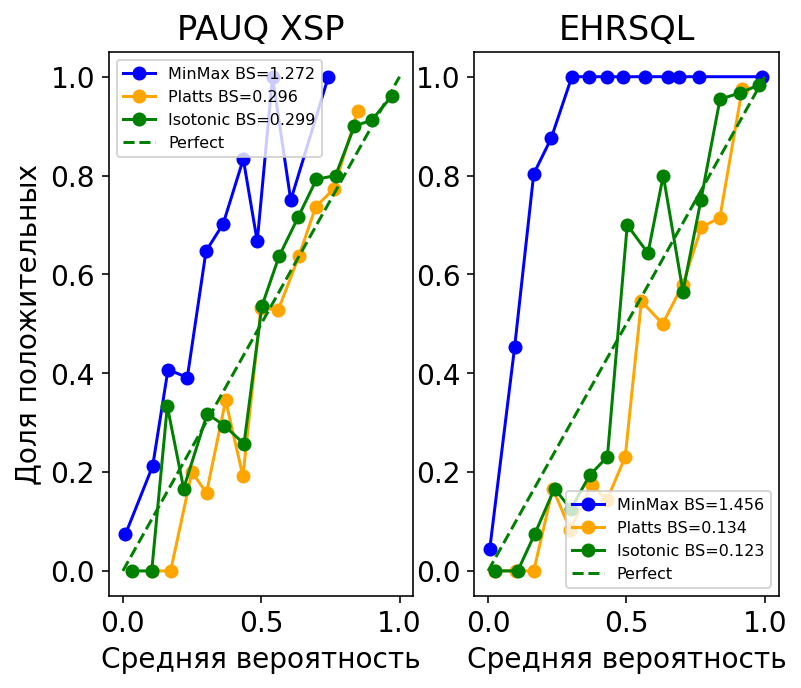

In [14]:
selected_model_name = 't5-3b'

model_name_list = ['t5-large', 't5-3b', 'llama3_lora', 'llama3_sft', 'dailsql']
splits = ['pauq_xsp', 'ehrsql']
calibration_scores_dict = dict()

total_bins=15
# ece_metric = ECEMetric(n_bins=total_bins, weighted=False, return_df=False, binning_strategy = 'adaptive')

for split in splits:
    calibration_scores_dict[split] = {}
    for model in model_name_list:
        off_model_name = data_constants.MODEL_NAMES[model]
        calibration_scores_dict[split][off_model_name] = {}

fig, axs = plt.subplots(1, len(splits), figsize=(6, 5))

calibration_metrics = {}

for idx, split_name in enumerate(splits):
    for model_name in model_name_list:
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                                  data_constants.SPLITS_PREDICTIONS_PATH, 
                                                                  data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            dev_tr = 1 - dev_tr
            test_tr = 1 - test_tr

            naive_calibrated_test_scores = make_naive_calibration(dev_sc, 1 - dev_tr, test_sc, 1- test_tr)
            sigmoid_calibration_test_scores = make_sigmoid_calibration(dev_sc, dev_tr, test_sc, test_tr)
            isotonic_calibration_test_scores = make_isotonic_calibration(dev_sc, dev_tr, test_sc, test_tr)
            # _, gmm_proba_preds = score_by_gmm(dev_sc, dev_tr, test_sc, test_tr)

            target_list = np.array([np.bincount(row).argmax() for row in test_tr]).reshape(-1,1)
            naive_probs = naive_calibrated_test_scores.mean(axis=1).reshape(-1,1)
            sigmoid_probs = sigmoid_calibration_test_scores.mean(axis=1).reshape(-1,1)
            isotonic_probs = isotonic_calibration_test_scores.mean(axis=1).reshape(-1,1)
            # gmm_probs = gmm_proba_preds.mean(axis=1).reshape(-1,1)

            naive_prob_true, naive_prob_pred = calibration_curve(1-target_list, naive_probs, n_bins=total_bins)
            sigmoid_prob_true, sigmoid_prob_pred = calibration_curve(target_list, sigmoid_probs, n_bins=total_bins)
            isotonic_prob_true, isotonic_prob_pred = calibration_curve(target_list, isotonic_probs, n_bins=total_bins)
            # gmm_prob_true, gmm_prob_pred = calibration_curve(target_list, gmm_probs, n_bins=total_bins)

            
            naive_bs = round(custom_brier_score(target_list, naive_probs), 3)
            sigmoid_bs = round(custom_brier_score(target_list, sigmoid_probs), 3)
            isotonic_bs = round(custom_brier_score(target_list, isotonic_probs), 3)
            # gmm_bs = round(custom_brier_score(target_list, gmm_probs), 3)



            naive_ece = round(ece_score_function(naive_probs, target_list, n_bins=total_bins), 3)
            sigmoid_ece = round(ece_score_function(sigmoid_probs, target_list, n_bins=total_bins), 3)
            isotonic_ece = round(ece_score_function(isotonic_probs, target_list, n_bins=total_bins), 3)
            # gmm_ece = round(ece_score_function(gmm_probs, target_list, n_bins=total_bins), 3)

            
            off_model_name = data_constants.MODEL_NAMES[model_name]
            calibration_scores_dict[split_name][off_model_name] = {
                                                                "MinMax": {"Brier": naive_bs, "ECE": naive_ece}, 
                                                                "Platts": {"Brier": sigmoid_bs, "ECE": sigmoid_ece}, 
                                                                "Isotonic": {"Brier": isotonic_bs, "ECE": isotonic_ece},
                                                                # "GMM": {"Brier": gmm_bs, "ECE": gmm_ece},

                                                              }
                                                                       
            if model_name == selected_model_name:
                axs[idx].plot(naive_prob_pred, naive_prob_true, '-o', label=f'MinMax BS={naive_bs}', color='blue')
                axs[idx].plot(sigmoid_prob_pred, sigmoid_prob_true, '-o', label=f'Platts BS={sigmoid_bs}', color='orange')
                axs[idx].plot(isotonic_prob_pred, isotonic_prob_true, '-o', label=f'Isotonic BS={isotonic_bs}', color='green')
                
                # axs[idx].plot(gmm_prob_pred, gmm_prob_true, '-o', label=f'GMM BS={gmm_bs}', color='purple')

                
                # axs[idx].plot(naive_prob_pred, naive_prob_true, '-o', label=f'MinMax ECE={naive_ece}', color='blue')
                # axs[idx].plot(sigmoid_prob_pred, sigmoid_prob_true, '-o', label=f'Sigmoid ECE={sigmoid_ece}', color='orange')
                # axs[idx].plot(isotonic_prob_pred, isotonic_prob_true, '-o', label=f'Isotonic ECE={isotonic_ece}', color='green')

                axs[idx].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

                plot_title = data_constants.SPLITS_NAMES[split_name]
                axs[idx].set_title(plot_title)

plt.rcParams.update({'font.size': 14})
axs[0].set_ylabel('Fraction of positives')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.legend(prop={'size': 8})

plt.show()


fig.savefig(f'confidence estimation data/calibration on {selected_model_name}.png', dpi=300, bbox_inches='tight', transparent=True)

In [202]:

brier_score_dict = {'MinMax': 0, 'Platts': 0, 'Isotonic': 0, 'GMM': 0}
ece_score_dict = {'MinMax': 0, 'Platts': 0, 'Isotonic': 0, 'GMM':0}
t = 0

for split_name in calibration_scores_dict:
    for model_name in calibration_scores_dict[split_name]:
        for method in calibration_scores_dict[split_name][model_name].keys():
            
            brier = calibration_scores_dict[split_name][model_name][method]['Brier']
            ece = calibration_scores_dict[split_name][model_name][method]['ECE']
            
            brier_score_dict[method] += brier
            ece_score_dict[method] += ece
            
        t += 1
            
for method in brier_score_dict:
    brier_score = round(brier_score_dict[method] / t, 2)
    brier_score_dict[method] = brier_score
    
    ece_score = round(ece_score_dict[method] / t, 2)
    ece_score_dict[method] = brier_score

    
brier = pd.DataFrame.from_dict(brier_score_dict, orient='index').T
ece = pd.DataFrame.from_dict(ece_score_dict,orient='index').T

best_calibration = pd.concat([brier, ece], axis=0)
best_calibration.index = ['Brier', 'ECE']
best_calibration

,MinMax,Platts,Isotonic,GMM
Brier,1.18,0.32,0.3,0.0
ECE,1.18,0.32,0.3,0.0


In [204]:
model2calibration_dict = dict()

method_names = ['MinMax', 'Platts', 'Isotonic']

for model in calibration_scores_dict['pauq_xsp']:
    model2calibration_dict[model] = {}
    for method in method_names:
        model2calibration_dict[model][method] = 0


for split_name in calibration_scores_dict:
    for model_name in calibration_scores_dict[split_name]:
        for method in method_names:
            
            brier = calibration_scores_dict[split_name][model_name][method]['Brier']
            # ece = calibration_scores_dict[split_name][model_name][method]['ECE']
            
            model2calibration_dict[model_name][method] += brier
            # model2calibration_dict[model_name][method] += ece
            
for model_name in model2calibration_dict:
    for method in model2calibration_dict[model_name]:
        brier_score = round(model2calibration_dict[model_name][method] / len(splits), 3)
        # ece_score = round(model2calibration_dict[model_name][method] / len(splits), 2)
        
        # model2calibration_dict[model_name][method]['Brier'] = brier_score
        model2calibration_dict[model_name][method] = brier_score
        
        
df = pd.concat({k: pd.DataFrame.from_dict(v, orient='index').T for k, v in model2calibration_dict.items()}, axis=0)

# df[['MinMax','Isotonic', 'Platts']]
df.index = [data_constants.MODEL_NAMES[name] for name in model_name_list]
df

,MinMax,Platts,Isotonic
T5-large,1.250,0.242,0.234
T5-3B,1.364,0.215,0.211
Llama3-8B LoRA,1.012,0.432,0.398
Llama3-8B SFT,1.098,0.377,0.350
DIAL-SQL,1.164,0.319,0.303


In [191]:
df.mean(axis=0)

MinMax      0.4158
Platts      0.3176
Isotonic    0.2992
GMM         0.5808
dtype: float64

### Calibration per split

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 869235.57it/s]


(1076, 3) (1076, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 911731.54it/s]


(1076, 3) (1076, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 905875.37it/s]


(1076, 1) (1076, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 907149.97it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1002904.69it/s]


(1076, 3) (1076, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 842106.24it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 987248.45it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 982323.93it/s]


(986, 1) (986, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 799764.79it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 793778.07it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 684699.30it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 804275.33it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 769697.33it/s]


(986, 1) (986, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 861939.09it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 697871.03it/s]


(986, 3) (986, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 576327.89it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 517744.10it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 416787.53it/s]


(1167, 1) (1167, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 416645.62it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 606912.93it/s]


(1167, 3) (1167, 3)


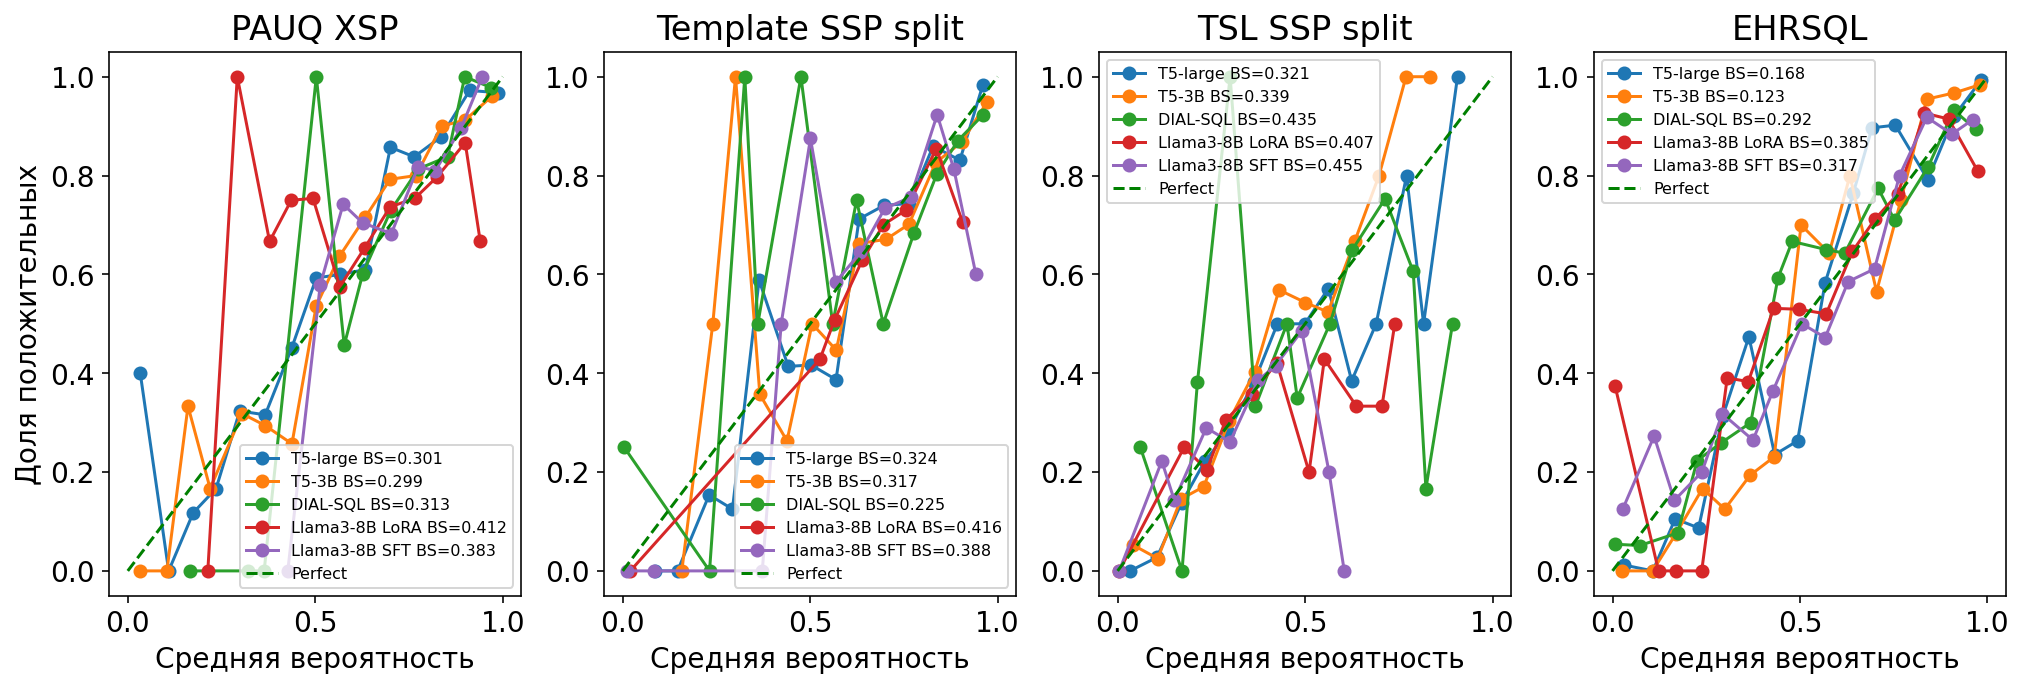

In [12]:
model_name_list = ['t5-large', 't5-3b', 'dailsql', 'llama3_lora', 'llama3_sft']
splits = ['pauq_xsp', 'template_ssp', 'tsl_ssp', 'ehrsql']

fig, axs = plt.subplots(1, len(splits), figsize=(17, 5))

for idx, split_name in enumerate(splits):
    for model_name in model_name_list:
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            dev_tr = 1 - dev_tr
            test_tr = 1 - test_tr

            isotonic_calibration_test_scores = make_isotonic_calibration(dev_sc, dev_tr, test_sc, test_tr)

            target_list = np.array([np.bincount(row).argmax() for row in test_tr]).reshape(-1,1)
            isotonic_probs = isotonic_calibration_test_scores.mean(axis=1).reshape(-1,1)

            isotonic_prob_true, isotonic_prob_pred = calibration_curve(target_list, isotonic_probs, n_bins=15)
            
            brier_score = round(custom_brier_score(target_list, isotonic_probs), 3)
            # isotonic_brier = round(brier_score_loss(target_list, isotonic_probs.flatten()), 3)
            # isotonic_ece = round(ece_score_function(isotonic_probs, target_list, n_bins=total_bins), 3)

            
            off_model_name = data_constants.MODEL_NAMES[model_name]
            axs[idx].plot(isotonic_prob_pred, isotonic_prob_true, '-o', label=f'{off_model_name} BS={brier_score}')

    axs[idx].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
    plot_title = data_constants.SPLITS_NAMES[split_name]
    axs[idx].set_title(plot_title)
    
    
axs[0].set_ylabel('Fraction of positives')


plt.rcParams.update({'font.size': 14})

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.legend(prop={'size': 8})

plt.show()

fig.savefig('confidence estimation data/calibration_per_split.png', dpi=300, bbox_inches='tight', transparent=True)


### Exec match to calibration plot

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 952325.62it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1002681.87it/s]


(1076, 3) (1076, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 965982.68it/s]


(1076, 3) (1076, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 637439.42it/s]


(1076, 3) (1076, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1076/1076 [00:00<00:00, 1102631.59it/s]


(1076, 1) (1076, 1)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1041446.42it/s]


(986, 3) (986, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 1019872.69it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 932908.58it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 976294.56it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 893793.76it/s]


(986, 1) (986, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 884238.56it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 802247.09it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 656025.34it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 899626.66it/s]


(986, 3) (986, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 986/986 [00:00<00:00, 904545.88it/s]


(986, 1) (986, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 641598.21it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 572351.82it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 582362.02it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 612226.74it/s]


(1167, 3) (1167, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1167/1167 [00:00<00:00, 611003.97it/s]


(1167, 1) (1167, 1)


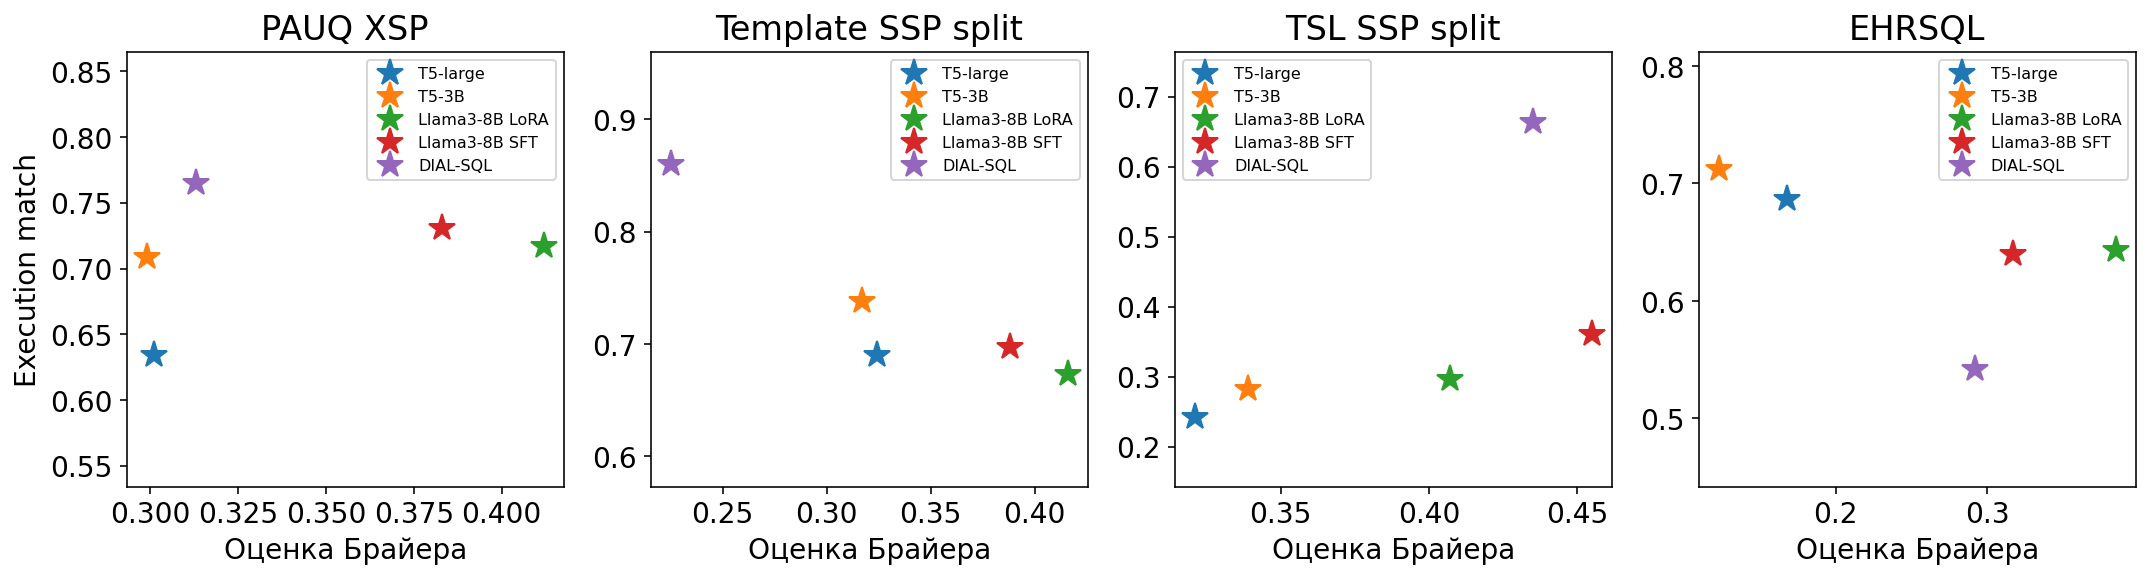

In [13]:
model_name_list = ['t5-large', 't5-3b', 'llama3_lora', 'llama3_sft', 'dailsql']
splits = ['pauq_xsp', 'template_ssp', 'tsl_ssp', 'ehrsql']

fig, axs = plt.subplots(1, len(splits), figsize=(18, 4))

for idx, split_name in enumerate(splits):
    max_ex, min_ex = 0, 1
    for model_name in model_name_list:
        scores, targets = support_functions.make_numpy_arrays(split_name, model_name, data_constants.SEED_LIST,
                                                              data_constants.SPLITS_PREDICTIONS_PATH, 
                                                              data_constants.GOLD_TEST_SPLIT_PATH)
        if scores is not None:
            dev_sc, dev_tr, test_sc, test_tr = support_functions.create_split(scores, targets)
            dev_tr = 1- dev_tr
            test_tr = 1 - test_tr

            isotonic_calibration_test_scores = make_isotonic_calibration(dev_sc, dev_tr, test_sc, test_tr)

            target_list = np.array([np.bincount(row).argmax() for row in test_tr]).reshape(-1,1)
            
            
            isotonic_probs = isotonic_calibration_test_scores.mean(axis=1).reshape(-1,1)

            execution_match = round(np.mean(test_tr.mean(axis=0)), 3)
            
            # isotonic_brier = round(brier_score_loss(target_list, isotonic_probs.flatten()), 3)
            brier_score = round(custom_brier_score(target_list, isotonic_probs), 3)
            # isotonic_ece = round(ece_score_function(isotonic_probs, target_list, n_bins=total_bins), 3)

            off_model_name = data_constants.MODEL_NAMES[model_name]
            axs[idx].plot(brier_score, execution_match, '*', markersize=14, label=off_model_name)
            
            # axs[idx].annotate(f'{off_model_name}', (isotonic_ece, execution_match), ha='left', va='bottom', fontsize=12)
            
            if execution_match > max_ex:
                max_ex = execution_match
            
            if execution_match < min_ex:
                min_ex = execution_match
                
    plot_title = data_constants.SPLITS_NAMES[split_name]
    axs[idx].set_title(plot_title)
    # axs[idx].set_xlim(0.0, 0.3)
    axs[idx].set_ylim(min_ex - 0.1, max_ex + 0.1)
    # print('lim: ', min_ex, max_match)
    
axs[0].set_ylabel('Execution match')
plt.rcParams.update({'font.size': 14})

for ax in axs:
    ax.set_xlabel('Brier score')

    ax.legend(prop={'size': 8})
    # ax.xaxis.label.set_fontsize(15)
    # ax.get_xticklabels().set_fontsize(15)
    # ax.get_yticklabels().set_fontsize(15)

plt.show()

fig.savefig('confidence estimation data/exec_match_to_calibration_error.png', dpi=300, bbox_inches='tight', transparent=True)